Using device: cuda
dat shape (neurons x trials): (39209, 5900)
PCA: 15 comps explain ≥90% variance.


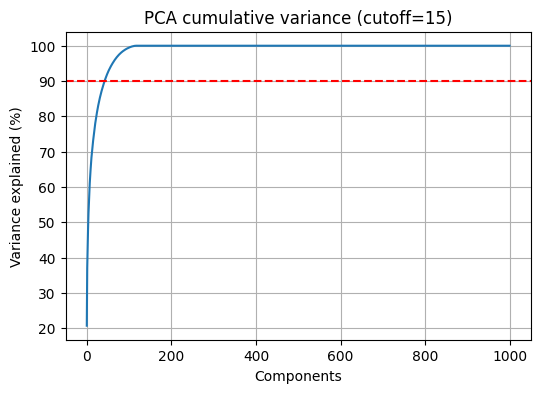


Training SAE on PCA features (all images)...
Epoch  10/60 | loss=0.000969
Epoch  20/60 | loss=0.000810
Epoch  30/60 | loss=0.000823
Epoch  40/60 | loss=0.000694
Epoch  50/60 | loss=0.000622
Epoch  60/60 | loss=0.000520
SAE latent shape: (5900, 100)

=== 5-Fold Crossvalidated Kendall τ (Held-out Images) ===
   neuron_idx  tau_PCA_mean  tau_PCA_std  tau_SAE_mean  tau_SAE_std  \
0       24711       -0.0066       0.1943       -0.0322       0.2666   
1       28019       -0.0408       0.1789        0.0081       0.1719   
2       17490       -0.0078       0.1963        0.0762       0.2093   
3        7070        0.0165       0.2232        0.0354       0.2724   
4        3454        0.0144       0.1978       -0.0089       0.1621   
5        7681        0.0096       0.2462        0.1679       0.2350   
6       27409       -0.0714       0.2065       -0.1529       0.1107   
7       21177        0.0286       0.1516        0.0657       0.2190   
8       30922        0.0825       0.2058        0.13

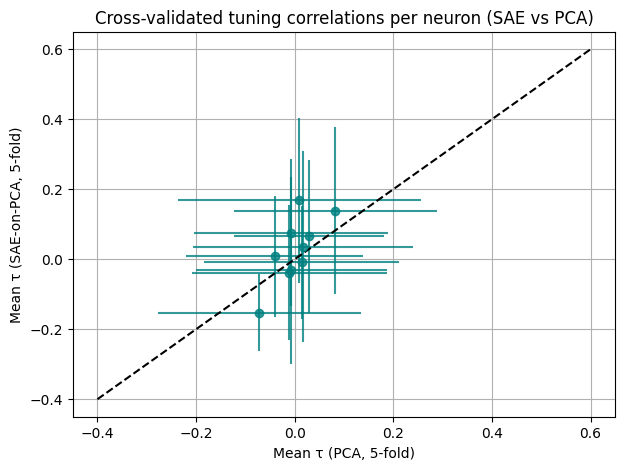

In [3]:
# ================================================================
#   5-FOLD CV: Verify SAE-vs-PCA effect on top SAE-preferring neurons
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, warnings, torch, torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax
from scipy.stats import kendalltau
from skbio.stats.composition import clr
from torch.utils.data import DataLoader, TensorDataset
from sklearn.exceptions import ConvergenceWarning

# ---------------------------------------------------------------
# Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ================================================================
# Load data
# ================================================================
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # (118, 1000)
Y_binary = (dat > 0).astype(int)

n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
assert n_samples == n_images * n_trials
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# CLR transform and PCA
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

pca_full = PCA()
pca_full.fit(X_trials_clr)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
n_components_90=15
print(f"PCA: {n_components_90} comps explain ≥90% variance.")

pca = PCA(n_components=n_components_90)
X_pca_full = pca.fit_transform(X_trials_clr)

plt.figure(figsize=(6,4))
plt.plot(cum_var*100)
plt.axhline(90, color='r', linestyle='--')
plt.title(f'PCA cumulative variance (cutoff={n_components_90})')
plt.xlabel('Components'); plt.ylabel('Variance explained (%)')
plt.grid(True); plt.show()

# ================================================================
# Train Sparse Autoencoder on PCA features
# ================================================================
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

print("\nTraining SAE on PCA features (all images)...")
sae_model, sae_scaler = train_sae(X_pca_full)
Z_full = encode(sae_model, sae_scaler, X_pca_full)
print(f"SAE latent shape: {Z_full.shape}")

# ================================================================
# 5-Fold Crossvalidation on Top SAE-preferring Neurons
# ================================================================
top_sae_neurons = [24711, 28019, 17490, 7070, 3454, 7681, 27409, 21177, 30922, 37867]

def compute_tau(y_true, y_pred, img_ids):
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    tau, _ = kendalltau(agg["y"], agg["p"], nan_policy="omit")
    return tau

records = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(n_images)))

for nid in top_sae_neurons:
    y_all = Y_binary[nid]
    tau_pca_folds, tau_sae_folds = [], []

    for train_img_idx, test_img_idx in folds:
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full, test_img_idx)
        Xp_train, Xp_test = X_pca_full[train_mask], X_pca_full[test_mask]
        Z_train, Z_test   = Z_full[train_mask], Z_full[test_mask]
        y_train, y_test   = y_all[train_mask], y_all[test_mask]
        test_img_ids      = img_ids_full[test_mask]

        # PCA logistic regression
        log_pca = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_pca.fit(Xp_train, y_train)
        y_pred_pca = log_pca.predict_proba(Xp_test)[:,1]
        tau_pca = compute_tau(y_test, y_pred_pca, test_img_ids)
        tau_pca_folds.append(tau_pca)

        # SAE logistic regression
        log_sae = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:,1]
        tau_sae = compute_tau(y_test, y_pred_sae, test_img_ids)
        tau_sae_folds.append(tau_sae)

    records.append({
        "neuron_idx": nid,
        "tau_PCA_mean": np.nanmean(tau_pca_folds),
        "tau_PCA_std": np.nanstd(tau_pca_folds),
        "tau_SAE_mean": np.nanmean(tau_sae_folds),
        "tau_SAE_std": np.nanstd(tau_sae_folds),
        "delta_tau_mean": np.nanmean(np.array(tau_sae_folds) - np.array(tau_pca_folds))
    })

df_cv = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Kendall τ (Held-out Images) ===")
print(df_cv.round(4))

# ================================================================
# Visualization
# ================================================================
plt.figure(figsize=(7,5))
plt.errorbar(df_cv["tau_PCA_mean"], df_cv["tau_SAE_mean"],
             xerr=df_cv["tau_PCA_std"], yerr=df_cv["tau_SAE_std"],
             fmt='o', alpha=0.8, color='teal')
plt.plot([-0.4,0.6],[-0.4,0.6],'k--')
plt.xlabel("Mean τ (PCA, 5-fold)")
plt.ylabel("Mean τ (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated tuning correlations per neuron (SAE vs PCA)")
plt.grid(True)
plt.show()
